In [1]:
import numpy as np
import pandas as pd
import sklearn
from tensorflow.keras.utils import plot_model
import string
import os
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from helper_functions import plot_loss_curves, calculate_results # get helper functions
from tensorflow.keras import mixed_precision, layers
from tensorflow.keras.layers.experimental import preprocessing
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from tensorflow.keras.layers import TextVectorization
from random import choice

In [2]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git
!ls pubmed-rct

fatal: destination path 'pubmed-rct' already exists and is not an empty directory.
PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


In [3]:
# check files dataset 
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign

dev.txt   test.txt  train.txt


In [4]:
data_directory = "pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"

In [5]:
file_names = [data_directory + filename for filename in os.listdir(data_directory)]
file_names

['pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt']

In [6]:
# read the lines of a document
def get_lines(filename):
  with open(filename, "r") as f:
    return f.readlines()

In [7]:
def preprocess_text_with_line_numbers(filename):
  input_lines = get_lines(filename) # get all lines from filename
  abstract_lines = "" # create an empty abstract
  abstract_samples = [] # create an empty list of abstracts
  
  # loop through each line in target file
  for line in input_lines:
    if line.startswith("###"): # check to see if line is an ID line
      abstract_id = line
      abstract_lines = "" # reset abstract string
    elif line.isspace(): # check to see if line is a new line
      abstract_line_split = abstract_lines.splitlines() # split abstract into separate lines

      # Iterate through each line in abstract and count them at the same time
      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data = {} # create empty dict to store data from line
        target_text_split = abstract_line.split("\t") # split target label from text
        line_data["target"] = target_text_split[0] # get target label
        line_data["text"] = target_text_split[1].lower() # get target text and lower it
        line_data["line_number"] = abstract_line_number # what number line does the line appear in the abstract?
        line_data["total_lines"] = len(abstract_line_split) - 1 # how many total lines are in the abstract? (start from 0)
        abstract_samples.append(line_data) # add line data to abstract samples list
    
    else: # if the above conditions not fulfilled, the line contains a labelled sentence
      abstract_lines += line
  
  return abstract_samples

In [8]:
train_lines = get_lines(data_directory + "train.txt")
train_lines[:10]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

In [9]:
# get data from file and preprocess it
train_samples = preprocess_text_with_line_numbers(data_directory + "train.txt")
val_samples = preprocess_text_with_line_numbers(data_directory + "dev.txt") # dev is another name for validation set
test_samples = preprocess_text_with_line_numbers(data_directory + "test.txt")
len(train_samples), len(val_samples), len(test_samples)

(180040, 30212, 30135)

In [10]:
train_samples[:24]

[{'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'line_number': 0,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'line_number': 1,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'line_number': 2,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'line_number': 3,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'secondary outcome measures included the western ontari

In [11]:
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)
train_df.head(20)

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11
5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",5,11
6,RESULTS,there was a clinically relevant reduction in t...,6,11
7,RESULTS,the mean difference between treatment arms ( @...,7,11
8,RESULTS,"further , there was a clinically relevant redu...",8,11
9,RESULTS,these differences remained significant at @ we...,9,11


In [12]:
train_df.target.value_counts()

target
METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: count, dtype: int64

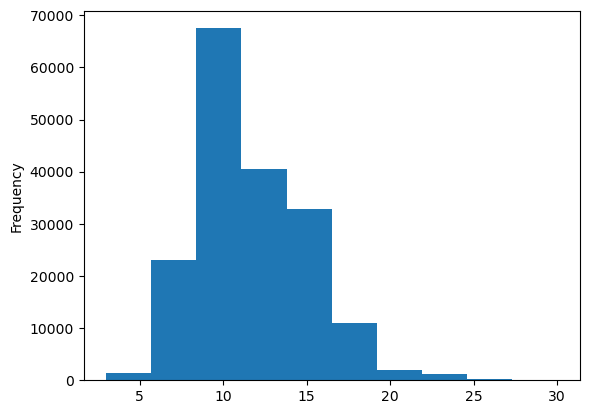

In [13]:
train_df.total_lines.plot.hist();

In [14]:
# Convert abstract text lines into lists 
train_sentences = train_df["text"].tolist()
val_sentences = val_df["text"].tolist()
test_sentences = test_df["text"].tolist()
len(train_sentences), len(val_sentences), len(test_sentences)

(180040, 30212, 30135)

In [15]:
train_sentences

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

In [16]:
train_sentences[:10]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

In [17]:
# One hot encode labels
one_hot_encoder = OneHotEncoder(sparse_output=False)
train_labels_one_hot = one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1, 1))
val_labels_one_hot = one_hot_encoder.transform(val_df["target"].to_numpy().reshape(-1, 1))
test_labels_one_hot = one_hot_encoder.transform(test_df["target"].to_numpy().reshape(-1, 1))

train_labels_one_hot

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [18]:
# extract labels ("target" columns) and encode them into integers 
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df["target"].to_numpy())
val_labels_encoded = label_encoder.transform(val_df["target"].to_numpy())
test_labels_encoded = label_encoder.transform(test_df["target"].to_numpy())

# check what training labels look like
train_labels_encoded

array([3, 2, 2, ..., 4, 1, 1])

In [19]:
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
num_classes, class_names

(5,
 array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

In [20]:
# creating and fitting a pipeline
model_0 = Pipeline([
  ("tf-idf", TfidfVectorizer()),
  ("clf", MultinomialNB())
])

model_0.fit(X=train_sentences, 
            y=train_labels_encoded);

In [21]:
model_0.score(val_sentences, val_labels_encoded)

0.7218323844829869

In [22]:
baseline_preds = model_0.predict(val_sentences)
baseline_preds

array([4, 1, 3, ..., 4, 4, 1])

In [23]:
# Calculate baseline results
baseline_results = calculate_results(y_true=val_labels_encoded,
                                     y_pred=baseline_preds)
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

In [24]:
# checking average sentence length 
sentence_lengths = [len(sentence.split()) for sentence in train_sentences]
avg_sentence_length = np.mean(sentence_lengths)
avg_sentence_length

26.338269273494777

In [25]:
output_sequence_length = int(np.percentile(sentence_lengths, 95))
output_sequence_length # sentence length that covers 95% of the lengths

55

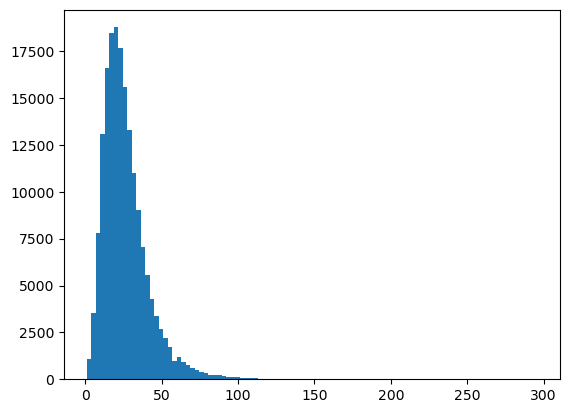

In [26]:
plt.hist(sentence_lengths, bins=100); # checking distribution

In [27]:
text_vectoriser = TextVectorization(max_tokens=68000, # number of words in vocabulary
                                    output_sequence_length=output_sequence_length) # desired output length of vectorised sequences

2023-11-20 15:15:24.501480: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Pro
2023-11-20 15:15:24.501509: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 32.00 GB
2023-11-20 15:15:24.501516: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 10.67 GB
2023-11-20 15:15:24.501553: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-11-20 15:15:24.501575: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [28]:
text_vectoriser.adapt(train_sentences)

2023-11-20 15:15:25.562732: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


In [29]:
target_sentence = choice(train_sentences)
# How many words in our training vocabulary?
rct_20k_text_vocab = text_vectoriser.get_vocabulary()

print(f"Text: {target_sentence}")
print(f"\nVectorised text:\n{text_vectoriser([target_sentence])}")
print(f"\nText legnth: {len(target_sentence.split())}")

print(f"Number of words in vocabulary: {len(rct_20k_text_vocab)}"), 
print(f"Most common words in the vocabulary: {rct_20k_text_vocab[:5]}")
print(f"Least common words in the vocabulary: {rct_20k_text_vocab[-5:]}")

Text: a total of @ white or african-american men and women with uncomplicated hypertension .

Vectorised text:
[[    8    76     4  1115    16 10885   309     3    90     7  2916   659
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]

Text legnth: 14
Number of words in vocabulary: 64841
Most common words in the vocabulary: ['', '[UNK]', 'the', 'and', 'of']
Least common words in the vocabulary: ['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


In [30]:
text_vectoriser.get_config()

{'name': 'text_vectorization',
 'trainable': True,
 'dtype': 'string',
 'batch_input_shape': (None,),
 'max_tokens': 68000,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None,
 'encoding': 'utf-8',
 'vocabulary_size': 64841}

In [31]:
# token embedding layer
token_embed = layers.Embedding(input_dim=len(rct_20k_text_vocab), # vocabulary length
                               output_dim=128, 
                               mask_zero=True,
                               name="token_embedding") 

print(f"before vectorisation:\n{target_sentence}\n")
vectorised_sentence = text_vectoriser([target_sentence])
print(f"after vectorisation (before embedding):\n{vectorised_sentence}\n")
embedded_sentence = token_embed(vectorised_sentence)
print(f"after embedding:\n{embedded_sentence}\n")
print(f"embedded sentence shape: {embedded_sentence.shape}")

before vectorisation:
a total of @ white or african-american men and women with uncomplicated hypertension .

after vectorisation (before embedding):
[[    8    76     4  1115    16 10885   309     3    90     7  2916   659
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]

after embedding:
[[[ 0.00504287 -0.0409434  -0.00696385 ...  0.04455988  0.03999641
   -0.00306321]
  [ 0.01731296 -0.00223942  0.02050162 ... -0.01679239  0.04764617
   -0.03240283]
  [-0.04419082  0.00605978 -0.018374   ... -0.02405073 -0.03490982
   -0.03045924]
  ...
  [-0.01213852  0.02512315 -0.03981823 ...  0.00348804  0.03886601
   -0.02387047]
  [-0.01213852  0.02512315 -0.03981823 ...  0.00348804  0.03886601
   -0.02387047]
  [-0.01213852  0.02512315 -0.03981823 ...  0.00348804  0.03886601
  

In [32]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
valid_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))

train_dataset

<_TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [33]:
# making datasets more efficient to load
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
valid_dataset = valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [34]:
# model_1: 1D convolutional model
inputs = layers.Input(shape=(1,), dtype=tf.string)
text_vectors = text_vectoriser(inputs) # vectorise text inputs
token_embeddings = token_embed(text_vectors) # create embedding
x = layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(token_embeddings)
x = layers.GlobalAveragePooling1D()(x) # condense the output of feature vector
outputs = layers.Dense(num_classes, activation="softmax")(x)
model_1 = tf.keras.Model(inputs, outputs)

model_1.compile(loss="categorical_crossentropy", #sparse_categorical_crossentropy for integer form labels 
                optimizer=tf.keras.optimizers.legacy.Adam(),
                metrics=["accuracy"])

In [35]:
model_1_history = model_1.fit(train_dataset,
                              steps_per_epoch=int(0.1 * len(train_dataset)),
                              epochs=3,
                              validation_data=valid_dataset,
                              validation_steps=int(0.1 * len(valid_dataset)))    

Epoch 1/3
562/562 [==============================] - 18s 32ms/step - loss: 0.9151 - accuracy: 0.6398 - val_loss: 0.6883 - val_accuracy: 0.7367
Epoch 2/3
562/562 [==============================] - 17s 29ms/step - loss: 0.6628 - accuracy: 0.7546 - val_loss: 0.6390 - val_accuracy: 0.7729
Epoch 3/3
562/562 [==============================] - 17s 30ms/step - loss: 0.6226 - accuracy: 0.7727 - val_loss: 0.6020 - val_accuracy: 0.7819


In [36]:
model_1.evaluate(valid_dataset)

945/945 [==============================] - 9s 9ms/step - loss: 0.6031 - accuracy: 0.7837


[0.6030813455581665, 0.7836621403694153]

In [37]:
model_1_pred_probs = model_1.predict(valid_dataset)
model_1_pred_probs

945/945 [==============================] - 2s 2ms/step


array([[4.08991337e-01, 2.08740190e-01, 6.17964268e-02, 2.90658534e-01,
        2.98135541e-02],
       [3.87247533e-01, 3.30407381e-01, 9.72423330e-03, 2.63885558e-01,
        8.73530190e-03],
       [1.18617825e-01, 7.00832577e-03, 1.90196256e-03, 8.72433722e-01,
        3.81792815e-05],
       ...,
       [5.45779403e-06, 1.03973073e-03, 9.86599014e-04, 3.50499090e-06,
        9.97964740e-01],
       [5.10527566e-02, 4.67910558e-01, 7.65213072e-02, 6.31031469e-02,
        3.41412216e-01],
       [2.20038906e-01, 5.98841250e-01, 4.61587459e-02, 6.44779801e-02,
        7.04830736e-02]], dtype=float32)

In [38]:
# converting prediction probabilities to classes
model_1_preds = tf.argmax(model_1_pred_probs, axis=1)
model_1_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 1, 1])>

In [39]:
model_1_results = calculate_results(y_true=val_labels_encoded, y_pred=model_1_preds)
model_1_results

{'accuracy': 78.36621210115186,
 'precision': 0.7804828389330639,
 'recall': 0.7836621210115186,
 'f1': 0.7811463275800867}

In [40]:
# model 2

In [41]:
tf_hub_embedding_layer = hub.KerasLayer("https://www.kaggle.com/models/google/universal-sentence-encoder/frameworks/TensorFlow2/variations/universal-sentence-encoder/versions/2",
                                        trainable=False,
                                        name="universal_sentence_encoder")

In [42]:
# teting out embedding on sentences
random_training_sentence = choice(train_sentences)
print(f"Random sentence:\n{random_training_sentence}\n")
use_embedded_sentence = tf_hub_embedding_layer([random_training_sentence])
print(f"after embedding:\n{use_embedded_sentence[0][:30]} (truncated output)...\n")
print(f"sentence embedding length:\n{len(use_embedded_sentence[0])}")

Random sentence:
the intervention produced a significant decrease in alcohol consumption : participants in the self-affirming implementation intention condition consumed @ fewer grams of pure alcohol per day at the end of the study than adolescents who completed the distractor task .

after embedding:
[ 0.01114147 -0.00917911 -0.04524389 -0.0516997  -0.03362209  0.01811499
  0.04769315  0.06370849  0.04734636  0.04711324  0.03669582 -0.04295033
  0.05155574 -0.00407822 -0.08326467 -0.06344737 -0.07517622  0.05057832
 -0.06347509 -0.06689747 -0.04052325  0.04424395 -0.05273061 -0.06606589
  0.00345112 -0.00373818 -0.02315559 -0.04056568 -0.06719039 -0.04269909] (truncated output)...

sentence embedding length:
512


In [43]:
inputs = layers.Input(shape=[], dtype=tf.string)
pretrained_embedding = tf_hub_embedding_layer(inputs) # tokenize text and create embedding
x = layers.Dense(128, activation="relu")(pretrained_embedding) # add a fully connected layer on top of the embedding
# Note: you could add more layers here if you wanted to
outputs = layers.Dense(5, activation="softmax")(x) # create the output layer
model_2 = tf.keras.Model(inputs=inputs,
                        outputs=outputs)

# Compile the model
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.legacy.Adam(),
                metrics=["accuracy"])

model_2.fit(train_dataset,
            steps_per_epoch=int(0.1 * len(train_dataset)),
            epochs=3,
            validation_data=valid_dataset,
            validation_steps=int(0.1 * len(valid_dataset)))

Epoch 1/3
562/562 [==============================] - 44s 76ms/step - loss: 0.9143 - accuracy: 0.6539 - val_loss: 0.8102 - val_accuracy: 0.6915
Epoch 2/3
562/562 [==============================] - 41s 72ms/step - loss: 0.7855 - accuracy: 0.6952 - val_loss: 0.7838 - val_accuracy: 0.6978
Epoch 3/3
562/562 [==============================] - 40s 71ms/step - loss: 0.7853 - accuracy: 0.7002 - val_loss: 0.7854 - val_accuracy: 0.6971


In [44]:
model_2.evaluate(valid_dataset)

945/945 [==============================] - 68s 72ms/step - loss: 0.7810 - accuracy: 0.6980


[0.7810397148132324, 0.6980007886886597]

In [45]:
model_2_pred_probs = model_2.predict(valid_dataset)
model_2_pred_probs

945/945 [==============================] - 95s 100ms/step


array([[0.41562328, 0.37896335, 0.00177367, 0.19595851, 0.00768121],
       [0.34122214, 0.51024747, 0.00135231, 0.14527602, 0.00190201],
       [0.19861129, 0.2084411 , 0.01477541, 0.5227367 , 0.05543549],
       ...,
       [0.00335523, 0.00679686, 0.05486796, 0.00187619, 0.93310374],
       [0.00570588, 0.04462071, 0.19581759, 0.00239997, 0.7514557 ],
       [0.16723715, 0.12218926, 0.6313572 , 0.00380237, 0.07541401]],
      dtype=float32)

In [46]:
# converting predictions with feature extraction model to classes
model_2_preds = tf.argmax(model_2_pred_probs, axis=1)
model_2_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 2])>

In [47]:
model_2_results = calculate_results(y_true=val_labels_encoded, y_pred=model_2_preds)
model_2_results

{'accuracy': 69.80007943863366,
 'precision': 0.6976486980725599,
 'recall': 0.6980007943863366,
 'f1': 0.6951512049600458}

In [48]:
# model 3

In [49]:
# function to split sentences into characters
def split_chars(text):
  return " ".join(list(text))

split_chars(random_training_sentence)

't h e   i n t e r v e n t i o n   p r o d u c e d   a   s i g n i f i c a n t   d e c r e a s e   i n   a l c o h o l   c o n s u m p t i o n   :   p a r t i c i p a n t s   i n   t h e   s e l f - a f f i r m i n g   i m p l e m e n t a t i o n   i n t e n t i o n   c o n d i t i o n   c o n s u m e d   @   f e w e r   g r a m s   o f   p u r e   a l c o h o l   p e r   d a y   a t   t h e   e n d   o f   t h e   s t u d y   t h a n   a d o l e s c e n t s   w h o   c o m p l e t e d   t h e   d i s t r a c t o r   t a s k   .'

In [50]:
train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]
print(train_chars[0])

t o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .


In [51]:
# average character length?
char_lens = [len(sentence) for sentence in train_sentences]
mean_char_len = np.mean(char_lens)
mean_char_len

149.3662574983337

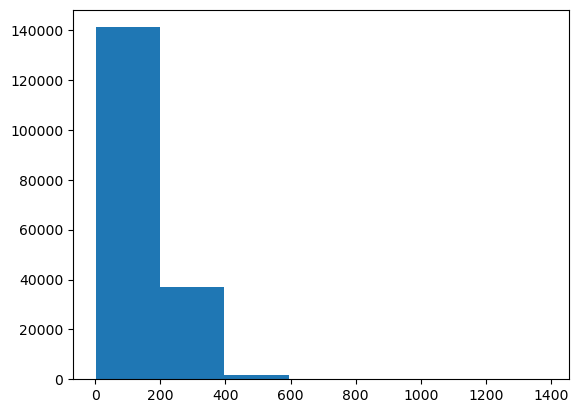

In [52]:
plt.hist(char_lens, bins=7);

In [53]:
output_sequence_character_len = int(np.percentile(char_lens, 95))
output_sequence_character_len

290

In [54]:
# keyboard characters for char-level embedding
alphabet = string.ascii_lowercase + string.digits + string.punctuation
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [55]:
# char-level token vectoriser instance
num_of_char_tokens = len(alphabet) + 2 # num of characters in alphabet + space + OOV token
char_vectoriser = TextVectorization(max_tokens=num_of_char_tokens,  
                                    output_sequence_length=output_sequence_character_len,
                                    standardize="lower_and_strip_punctuation",
                                    name="char_vectoriser")

char_vectoriser.adapt(train_chars)

In [56]:
character_vocab = char_vectoriser.get_vocabulary()
random_train_characters = choice(train_chars)

print(f"number of different characters in character vocab: {len(character_vocab)}")
print(f"10 most common characters: {character_vocab[:10]}")
print(f"10 least common characters: {character_vocab[-10:]}")

print(f"charified text:\n{random_train_characters}")
print(f"\nlength of chars: {len(random_train_characters.split())}")
vectorised_characters = char_vectoriser([random_train_characters])
print(f"\nvectorised chars:\n{vectorised_characters}")
print(f"\n vectorised chars llength: {len(vectorised_characters[0])}")

number of different characters in character vocab: 28
10 most common characters: ['', '[UNK]', 'e', 't', 'i', 'a', 'n', 'o', 'r', 's']
10 least common characters: ['g', 'y', 'w', 'v', 'b', 'k', 'x', 'z', 'q', 'j']
charified text:
s e p a r a t e l y   ,   i n   @   ,   @   a n d   @   d a y s   o f   t r e a t m e n t   ,   t h e   c l i n i c a l   e f f i c a c y   ,   b e h a v i o r   n e r v e   d e t e r m i n a t i o n   s c o r e   a n d   a d v e r s e   r e a c t i o n   w e r e   o b s e r v e d   i n   t h e   t w o   g r o u p s   .

length of chars: 132

vectorised chars:
[[ 9  2 14  5  8  5  3  2 12 19  4  6  5  6 10 10  5 19  9  7 17  3  8  2
   5  3 15  2  6  3  3 13  2 11 12  4  6  4 11  5 12  2 17 17  4 11  5 11
  19 22  2 13  5 21  4  7  8  6  2  8 21  2 10  2  3  2  8 15  4  6  5  3
   4  7  6  9 11  7  8  2  5  6 10  5 10 21  2  8  9  2  8  2  5 11  3  4
   7  6 20  2  8  2  7 22  9  2  8 21  2 10  4  6  3 13  2  3 20  7 18  8
   7 16 14  9  0  0  0  0  0  0  0  0

In [57]:
char_embed = layers.Embedding(input_dim=num_of_char_tokens, # number of different characters
                              output_dim=25, # same as that in https://arxiv.org/pdf/1612.05251.pdf
                              name="char_embed")

# Test out character embedding layer
print(f"charified text before vectorisation and embedding:\n{random_train_characters}\n")
char_embed_example = char_embed(char_vectoriser([random_train_characters]))
print(f"embedded chars after vectorisation and embedding:\n{char_embed_example}\n")
print(f"character embedding shape: {char_embed_example.shape}")

charified text before vectorisation and embedding:
s e p a r a t e l y   ,   i n   @   ,   @   a n d   @   d a y s   o f   t r e a t m e n t   ,   t h e   c l i n i c a l   e f f i c a c y   ,   b e h a v i o r   n e r v e   d e t e r m i n a t i o n   s c o r e   a n d   a d v e r s e   r e a c t i o n   w e r e   o b s e r v e d   i n   t h e   t w o   g r o u p s   .

embedded chars after vectorisation and embedding:
[[[-0.01184988 -0.00837214  0.00036978 ...  0.03876417  0.02259139
   -0.04737462]
  [ 0.03187824  0.02564839 -0.01303506 ...  0.00066137  0.00576223
    0.0280642 ]
  [-0.01579764 -0.00918397 -0.03789629 ...  0.01253021  0.04788912
    0.0196101 ]
  ...
  [-0.04160034 -0.00033163  0.02216334 ...  0.02255346 -0.04714156
    0.01087672]
  [-0.04160034 -0.00033163  0.02216334 ...  0.02255346 -0.04714156
    0.01087672]
  [-0.04160034 -0.00033163  0.02216334 ...  0.02255346 -0.04714156
    0.01087672]]]

character embedding shape: (1, 290, 25)


In [58]:
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars, train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_dataset = tf.data.Dataset.from_tensor_slices((val_chars, val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

train_char_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [59]:
# conv1d with charcater embedding
inputs = layers.Input(shape=(1,), dtype="string")
char_vectors = char_vectoriser(inputs)
char_embeddings = char_embed(char_vectors)
x = layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(char_embeddings)
x = layers.GlobalMaxPool1D()(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)
model_3 = tf.keras.Model(inputs=inputs,
                         outputs=outputs,
                         name="model_3_conv1D_char_embedding")

# Compile model
model_3.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.legacy.Adam(),
                metrics=["accuracy"])

model_3_history = model_3.fit(train_char_dataset,
                              steps_per_epoch=int(0.1 * len(train_char_dataset)),
                              epochs=3,
                              validation_data=val_char_dataset,
                              validation_steps=int(0.1 * len(val_char_dataset)))

Epoch 1/3
562/562 [==============================] - 25s 42ms/step - loss: 1.2641 - accuracy: 0.4875 - val_loss: 1.0556 - val_accuracy: 0.5828
Epoch 2/3
562/562 [==============================] - 21s 37ms/step - loss: 1.0211 - accuracy: 0.5883 - val_loss: 0.9384 - val_accuracy: 0.6320
Epoch 3/3
562/562 [==============================] - 20s 35ms/step - loss: 0.9325 - accuracy: 0.6341 - val_loss: 0.8613 - val_accuracy: 0.6659


In [60]:
model_3.evaluate(val_char_dataset)

945/945 [==============================] - 18s 19ms/step - loss: 0.8952 - accuracy: 0.6507


[0.895172119140625, 0.6506686210632324]

In [61]:
model_3_pred_probs = model_3.predict(val_char_dataset)
model_3_pred_probs

945/945 [==============================] - 3s 3ms/step


array([[0.12418009, 0.34401083, 0.07570006, 0.3419259 , 0.11418314],
       [0.2175712 , 0.44987035, 0.01829476, 0.23994486, 0.07431882],
       [0.13465138, 0.26085365, 0.09804669, 0.4792144 , 0.02723388],
       ...,
       [0.0342055 , 0.05543867, 0.11631111, 0.02470437, 0.76934046],
       [0.03064665, 0.17507333, 0.18377836, 0.03286351, 0.5776381 ],
       [0.3066644 , 0.34513772, 0.27070776, 0.05027996, 0.02721019]],
      dtype=float32)

In [62]:
# converting predictions to classes
model_3_preds = tf.argmax(model_3_pred_probs, axis=1)
model_3_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([1, 1, 3, ..., 4, 4, 1])>

In [63]:
model_3_results = calculate_results(y_true=val_labels_encoded, y_pred=model_3_preds)
model_3_results

{'accuracy': 65.06686084999338,
 'precision': 0.6496183131867396,
 'recall': 0.6506686084999338,
 'f1': 0.6400389736946451}

In [64]:
# model 4

In [65]:
# combining chars and tokens into a dataset
train_char_token_data = tf.data.Dataset.from_tensor_slices((train_sentences, train_chars)) # make data
train_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot) # make labels
train_char_token_dataset = tf.data.Dataset.zip((train_char_token_data, train_char_token_labels)) # combine data and labels

# prefetching and batching train data
train_char_token_dataset = train_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE) 

# now for validation data
val_char_token_data = tf.data.Dataset.from_tensor_slices((val_sentences, val_chars))
val_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_char_token_dataset = tf.data.Dataset.zip((val_char_token_data, val_char_token_labels))
val_char_token_dataset = val_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

train_char_token_dataset, val_char_token_dataset

(<_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

In [66]:
# setting up token inputs/model
token_inputs = layers.Input(shape=[], dtype=tf.string, name="token_input")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_output = layers.Dense(128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs, outputs=token_output)

# setting up char inputs/model
char_inputs = layers.Input(shape=(1,), dtype=tf.string, name="char_input")
char_vectors = char_vectoriser(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(25))(char_embeddings)
char_model = tf.keras.Model(inputs=char_inputs, outputs=char_bi_lstm)

# concatenating token and char inputs (hybrid token embedding)
token_char_concat = layers.Concatenate(name="token_char_hybrid")([token_model.output, char_model.output])

combined_dropout = layers.Dropout(0.5)(token_char_concat)
combined_dense = layers.Dense(200, activation="relu")(combined_dropout)
final_dropout = layers.Dropout(0.5)(combined_dense)
output_layer = layers.Dense(num_classes, activation="softmax")(final_dropout)

model_4 = tf.keras.Model(inputs=[token_model.input, char_model.input],
                         outputs=output_layer,
                         name="model_4_token_and_char_embeddings")

model_4.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.legacy.Adam(),
                metrics=["accuracy"])

model_4_history = model_4.fit(train_char_token_dataset,
                              steps_per_epoch=int(0.1 * len(train_char_token_dataset)),
                              epochs=3,
                              validation_data=val_char_token_dataset,
                              validation_steps=int(0.1 * len(val_char_token_dataset)))

Epoch 1/3
562/562 [==============================] - 127s 221ms/step - loss: 0.9271 - accuracy: 0.6355 - val_loss: 0.7951 - val_accuracy: 0.6905
Epoch 2/3
562/562 [==============================] - 105s 187ms/step - loss: 0.8032 - accuracy: 0.6883 - val_loss: 0.7607 - val_accuracy: 0.7121
Epoch 3/3
562/562 [==============================] - 111s 197ms/step - loss: 0.8073 - accuracy: 0.6916 - val_loss: 0.7589 - val_accuracy: 0.7141


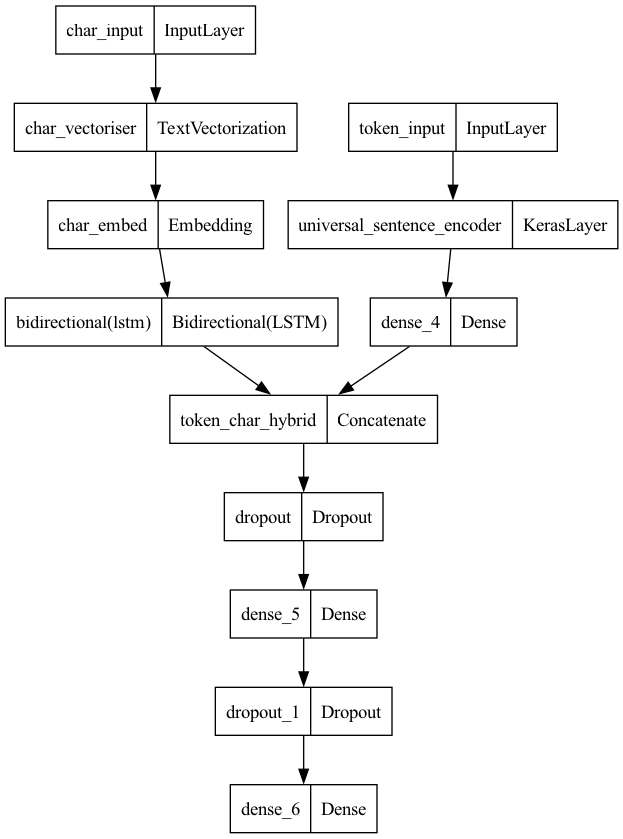

In [67]:
plot_model(model_4)

In [68]:
model_4.evaluate(val_char_token_dataset)

945/945 [==============================] - 154s 163ms/step - loss: 0.7642 - accuracy: 0.7084


[0.7642034292221069, 0.7083609104156494]

In [69]:
model_4_pred_probs = model_4.predict(val_char_token_dataset)
model_4_pred_probs

945/945 [==============================] - 176s 185ms/step


array([[0.4581004 , 0.34214526, 0.00224628, 0.19107342, 0.0064347 ],
       [0.45422646, 0.35282582, 0.00254953, 0.1889642 , 0.00143401],
       [0.28076422, 0.15224282, 0.01364932, 0.5214762 , 0.03186743],
       ...,
       [0.00519824, 0.00668134, 0.05715495, 0.00157134, 0.9293941 ],
       [0.01295949, 0.0439947 , 0.24800357, 0.0050836 , 0.6899586 ],
       [0.16742629, 0.17627831, 0.54352987, 0.01756535, 0.09520028]],
      dtype=float32)

In [70]:
model_4_preds = tf.argmax(model_4_pred_probs, axis=1)
model_4_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 4, 2])>

In [71]:
model_4_results = calculate_results(y_true=val_labels_encoded, y_pred=model_4_preds)
model_4_results

{'accuracy': 70.83609161922415,
 'precision': 0.7068476630936512,
 'recall': 0.7083609161922415,
 'f1': 0.7055616401653292}

In [72]:
# model 5

In [73]:
train_df.head()

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11


In [74]:
train_df["line_number"].value_counts()

line_number
0     15000
1     15000
2     15000
3     15000
4     14992
5     14949
6     14758
7     14279
8     13346
9     11981
10    10041
11     7892
12     5853
13     4152
14     2835
15     1861
16     1188
17      751
18      462
19      286
20      162
21      101
22       66
23       33
24       22
25       14
26        7
27        4
28        3
29        1
30        1
Name: count, dtype: int64

<Axes: ylabel='Frequency'>

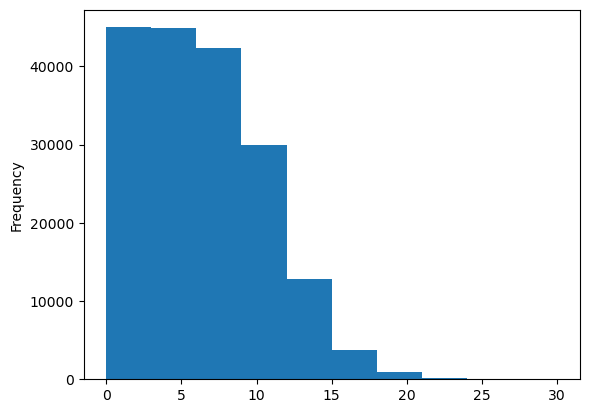

In [75]:
train_df.line_number.plot.hist()

In [76]:
train_line_numbers_one_hot = tf.one_hot(train_df["line_number"].to_numpy(), depth=15)
val_line_numbers_one_hot = tf.one_hot(val_df["line_number"].to_numpy(), depth=15)
test_line_numbers_one_hot = tf.one_hot(test_df["line_number"].to_numpy(), depth=15)

In [77]:
train_line_numbers_one_hot.shape

TensorShape([180040, 15])

In [78]:
train_line_numbers_one_hot[:20]

<tf.Tensor: shape=(20, 15), dtype=float32, numpy=
array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0

In [79]:
train_df["total_lines"].value_counts()

total_lines
11    24468
10    23639
12    22113
9     19400
13    18438
14    14610
8     12285
15    10768
7      7464
16     7429
17     5202
6      3353
18     3344
19     2480
20     1281
5      1146
21      770
22      759
23      264
4       215
24      200
25      182
26       81
28       58
3        32
30       31
27       28
Name: count, dtype: int64

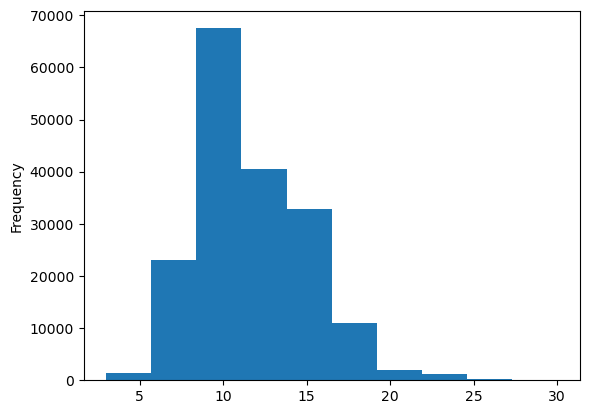

In [80]:
train_df.total_lines.plot.hist();

In [81]:
np.percentile(train_df.total_lines, 98) # a value of 20 covers 98% of samples

20.0

In [82]:
# Use TensorFlow to create one-hot-encoded tensors of our "total_lines" column 
train_total_lines_one_hot = tf.one_hot(train_df["total_lines"].to_numpy(), depth=20)
val_total_lines_one_hot = tf.one_hot(val_df["total_lines"].to_numpy(), depth=20)
test_total_lines_one_hot = tf.one_hot(test_df["total_lines"].to_numpy(), depth=20)

train_total_lines_one_hot.shape

TensorShape([180040, 20])

In [83]:
train_total_lines_one_hot[:10]

<tf.Tensor: shape=(10, 20), dtype=float32, numpy=
array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
     

In [85]:
# creating training and validation datasets for all four kinds of inputs
train_pos_char_token_data = tf.data.Dataset.from_tensor_slices((train_line_numbers_one_hot, # line numbers
                                                                train_total_lines_one_hot, # total lines
                                                                train_sentences, # train tokens
                                                                train_chars)) # train chars
train_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot) # train labels
train_pos_char_token_dataset = tf.data.Dataset.zip((train_pos_char_token_data, train_pos_char_token_labels)) # combine data and labels
train_pos_char_token_dataset = train_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE) # turn into batches and prefetch appropriately

# validation dataset
val_pos_char_token_data = tf.data.Dataset.from_tensor_slices((val_line_numbers_one_hot,
                                                              val_total_lines_one_hot,
                                                              val_sentences,
                                                              val_chars))
val_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_pos_char_token_dataset = tf.data.Dataset.zip((val_pos_char_token_data, val_pos_char_token_labels))
val_pos_char_token_dataset = val_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE) # turn into batches and prefetch appropriately

# check input shapes
train_pos_char_token_dataset, val_pos_char_token_dataset

(<_PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

In [86]:
# token inputs
token_inputs = layers.Input(shape=[], dtype="string", name="token_inputs")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_outputs = layers.Dense(128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs, outputs=token_outputs)

# char inputs
char_inputs = layers.Input(shape=(1,), dtype="string", name="char_inputs")
char_vectors = char_vectoriser(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(32))(char_embeddings)
char_model = tf.keras.Model(inputs=char_inputs, outputs=char_bi_lstm)

# line numbers inputs
line_number_inputs = layers.Input(shape=(15,), dtype=tf.int32, name="line_number_input")
x = layers.Dense(32, activation="relu")(line_number_inputs)
line_number_model = tf.keras.Model(inputs=line_number_inputs, outputs=x)

# total lines inputs
total_lines_inputs = layers.Input(shape=(20,), dtype=tf.int32, name="total_lines_input")
y = layers.Dense(32, activation="relu")(total_lines_inputs)
total_line_model = tf.keras.Model(inputs=total_lines_inputs, outputs=y)

# combining token and char embeddings into a hybrid embedding
combined_embeddings = layers.Concatenate(name="token_char_hybrid_embedding")([token_model.output,  char_model.output])
z = layers.Dense(256, activation="relu")(combined_embeddings)
z = layers.Dropout(0.5)(z)

# combining positional embeddings with combined token and char embeddings
z = layers.Concatenate(name="token_char_positional_embedding")([line_number_model.output, total_line_model.output, z])

# output layer
output_layer = layers.Dense(5, activation="softmax", name="output_layer")(z)

# putting model together
model_5 = tf.keras.Model(inputs=[line_number_model.input, total_line_model.input,
                                 token_model.input, char_model.input], outputs=output_layer)

# compiling
model_5.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2), # label smoothing to avoid overfitting
                optimizer=tf.keras.optimizers.legacy.Adam(),
                metrics=["accuracy"])

# fit token, char and positional embedding model
history_model_5 = model_5.fit(train_pos_char_token_dataset,
                              steps_per_epoch=int(0.1 * len(train_pos_char_token_dataset)),
                              epochs=3,
                              validation_data=val_pos_char_token_dataset,
                              validation_steps=int(0.1 * len(val_pos_char_token_dataset)))

Epoch 1/3
562/562 [==============================] - 208s 361ms/step - loss: 1.0928 - accuracy: 0.7286 - val_loss: 1.0112 - val_accuracy: 0.7892
Epoch 2/3
562/562 [==============================] - 144s 257ms/step - loss: 0.9966 - accuracy: 0.7966 - val_loss: 0.9860 - val_accuracy: 0.8019
Epoch 3/3
562/562 [==============================] - 142s 252ms/step - loss: 0.9994 - accuracy: 0.7958 - val_loss: 1.0124 - val_accuracy: 0.7906


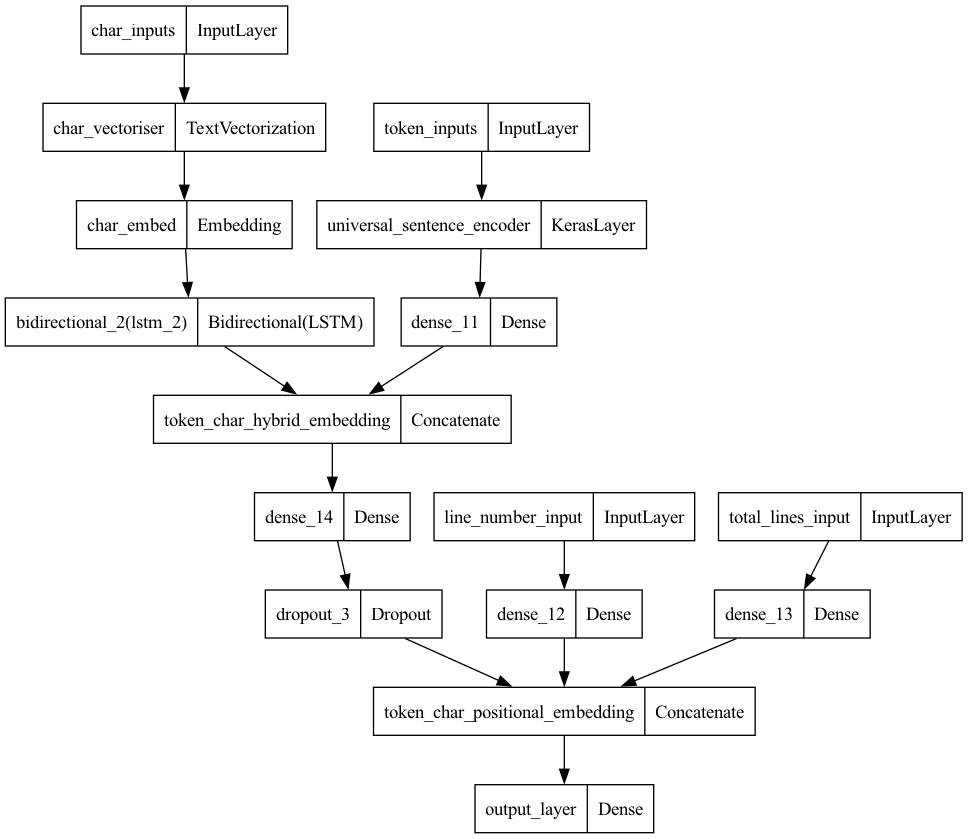

In [87]:
plot_model(model_5)

In [88]:
for layer in model_5.layers:
  print(layer, layer.trainable)

<keras.src.engine.input_layer.InputLayer object at 0x2be660a00> True
<keras.src.engine.input_layer.InputLayer object at 0x5bed1a0e0> True
<keras.src.layers.preprocessing.text_vectorization.TextVectorization object at 0x5226c67d0> True
<tensorflow_hub.keras_layer.KerasLayer object at 0x2c67cd930> False
<keras.src.layers.core.embedding.Embedding object at 0x52269de40> True
<keras.src.layers.core.dense.Dense object at 0x5bed80d30> True
<keras.src.layers.rnn.bidirectional.Bidirectional object at 0x5f4ee9870> True
<keras.src.layers.merging.concatenate.Concatenate object at 0x5bedb61a0> True
<keras.src.engine.input_layer.InputLayer object at 0x522c68430> True
<keras.src.engine.input_layer.InputLayer object at 0x63b607cd0> True
<keras.src.layers.core.dense.Dense object at 0x5e8a64700> True
<keras.src.layers.core.dense.Dense object at 0x5bedf63e0> True
<keras.src.layers.core.dense.Dense object at 0x5bedb7eb0> True
<keras.src.layers.regularization.dropout.Dropout object at 0x5e8a65450> True
<ke

In [89]:
model_5_pred_probs = model_5.predict(val_pos_char_token_dataset, verbose=1)
model_5_pred_probs

945/945 [==============================] - 204s 214ms/step


array([[0.27235276, 0.14001165, 0.00778194, 0.5468508 , 0.03300278],
       [0.33942872, 0.15996505, 0.03110223, 0.45542234, 0.01408165],
       [0.11787153, 0.14799275, 0.0530915 , 0.56465167, 0.11639253],
       ...,
       [0.09773771, 0.1140494 , 0.0720062 , 0.02996552, 0.68624115],
       [0.02456909, 0.36774406, 0.048299  , 0.01801498, 0.54137284],
       [0.2968855 , 0.28182733, 0.28314424, 0.02238288, 0.11576006]],
      dtype=float32)

In [90]:
model_5_preds = tf.argmax(model_5_pred_probs, axis=1)
model_5_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([3, 3, 3, ..., 4, 4, 0])>

In [91]:
model_5_results = calculate_results(y_true=val_labels_encoded, y_pred=model_5_preds)
model_5_results

{'accuracy': 78.06169733880577,
 'precision': 0.7946906601438818,
 'recall': 0.7806169733880577,
 'f1': 0.7739421069681536}

In [92]:
# comparing models

In [93]:
# combining model results into a df
all_model_results = pd.DataFrame({"baseline": baseline_results,
                                  "custom_token_embed_conv1d": model_1_results,
                                  "pretrained_token_embed": model_2_results,
                                  "custom_char_embed_conv1d": model_3_results,
                                  "hybrid_char_token_embed": model_4_results,
                                  "tribrid_pos_char_token_embed": model_5_results}).transpose()
all_model_results

,accuracy,precision,recall,f1
baseline,72.183238,0.718647,0.721832,0.698925
custom_token_embed_conv1d,78.366212,0.780483,0.783662,0.781146
pretrained_token_embed,69.800079,0.697649,0.698001,0.695151
custom_char_embed_conv1d,65.066861,0.649618,0.650669,0.640039
hybrid_char_token_embed,70.836092,0.706848,0.708361,0.705562
tribrid_pos_char_token_embed,78.061697,0.794691,0.780617,0.773942


In [94]:
all_model_results["accuracy"] = all_model_results["accuracy"]/100

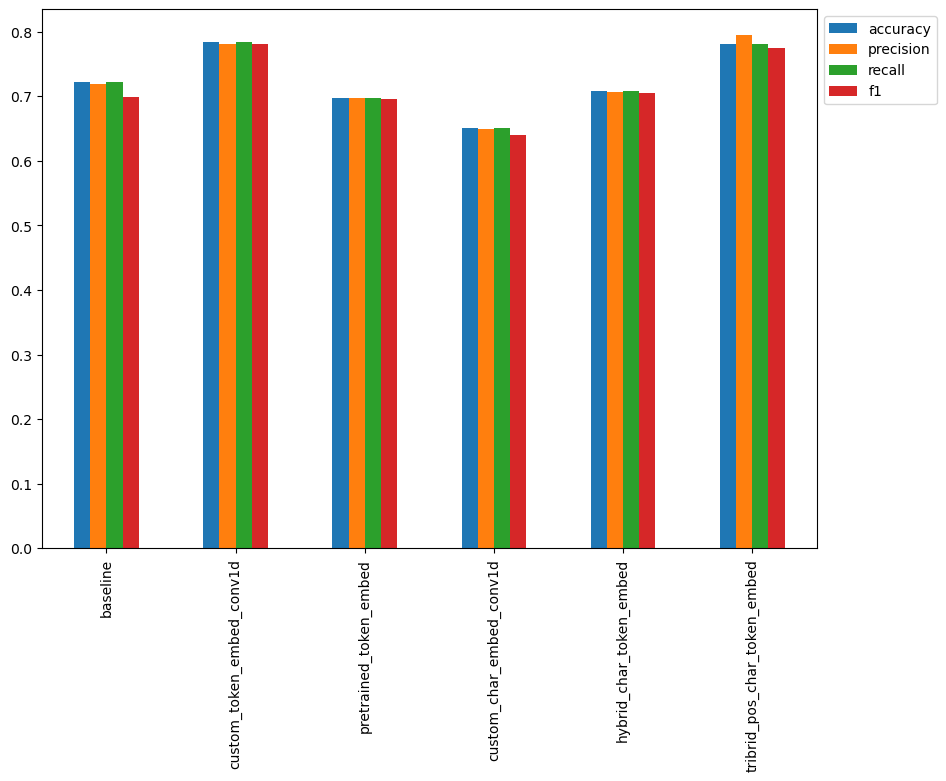

In [95]:
all_model_results.plot(kind="bar", figsize=(10, 7)).legend(bbox_to_anchor=(1.0, 1.0));

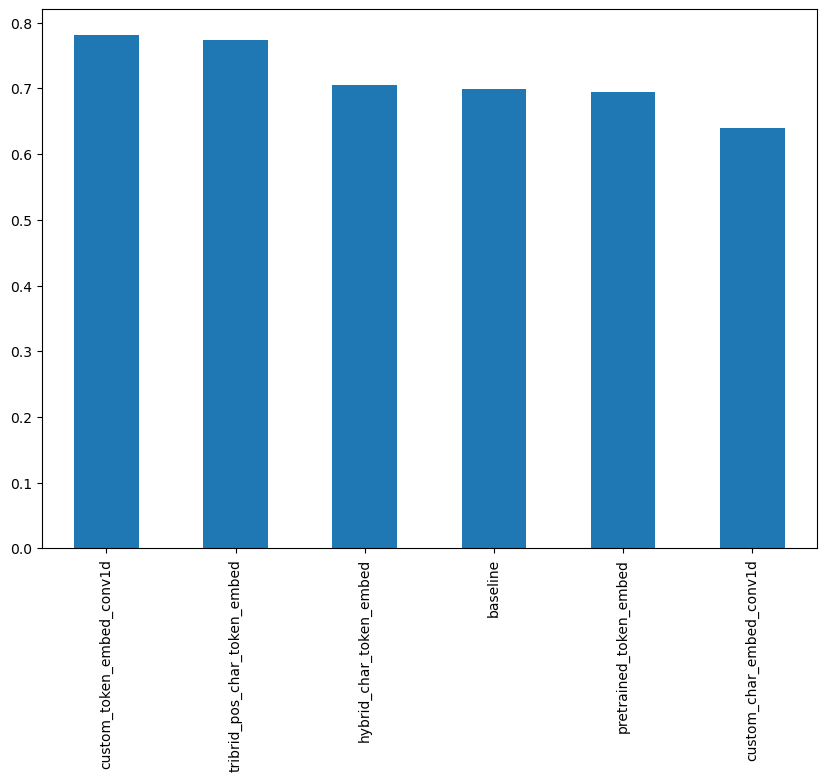

In [96]:
all_model_results.sort_values("f1", ascending=False)["f1"].plot(kind="bar", figsize=(10, 7));

In [98]:
# sacving model 5
model_1.save("custom_token_embed_conv1d") # model will be saved to path specified by string
model_5.save("skimlit_tribrid_model") # model will be saved to path specified by string

INFO:tensorflow:Assets written to: custom_token_embed_conv1d/assets


INFO:tensorflow:Assets written to: custom_token_embed_conv1d/assets


INFO:tensorflow:Assets written to: skimlit_tribrid_model/assets


INFO:tensorflow:Assets written to: skimlit_tribrid_model/assets
